# Weight Pruning

**Overview**

Magnitude-based weight pruning gradually zeroes out model weights during the training process to achieve model sparsity. Sparse models are easier to compress, and we can skip the zeroes during inference for latency improvements.

This technique brings improvements via model compression. In the future, framework support for this technique will provide latency improvements. We've seen up to 6x improvements in model compression with minimal loss of accuracy.

The technique is being evaluated in various speech applications, such as speech recognition and text-to-speech, and has been experimented on across various vision and translation models.

In this example we will be using Fashion MNIST dataset.
This example require Tensorflow 2.4 version or higher.

## Initial Setup

In [1]:
!nvidia-smi

Fri Mar 26 13:11:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 19.2MB/s 


## Helper Functions - To determine the file size

In [3]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

## Import the necessary modules

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from sklearn.metrics import accuracy_score
from sys import getsizeof

import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, GlobalAvgPool2D, Dropout

%load_ext tensorboard

## Load the Fashion MNIST dataset

The **[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)** dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

![](https://www.tensorflow.org/images/fashion-mnist-sprite.png)

## Baseline Model

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#Storing test labels
test_labels = y_test

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

#### Display the shape of the training as well testing images and labels

In [7]:
print("Training Image Shape: ",x_train.shape)
print("Training Label Shape", y_train.shape)
print("Testing Image Shape: ",x_test.shape)
print("Testing Label Shape", y_test.shape)

Training Image Shape:  (60000, 28, 28, 1)
Training Label Shape (60000, 10)
Testing Image Shape:  (10000, 28, 28, 1)
Testing Label Shape (10000, 10)


### Define the Hyperparameters

In [8]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES=10

### Creating the Data Pipeline

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = (
    train_ds
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
)

___Pipeline___ is ready!

### Visiualise the Training Images

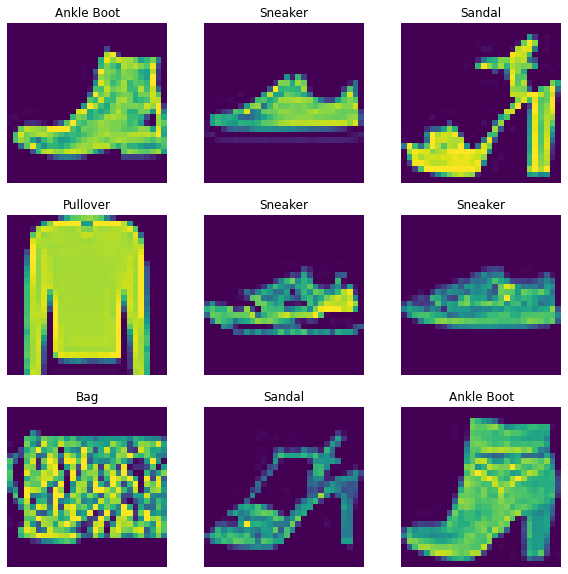

In [10]:
sample_images, sample_labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    plt.title(class_name[np.argmax(label.numpy().tolist())])
    plt.axis("off")

### Define the Model

In [11]:
def training_model():
    model = tf.keras.Sequential(
        [
            Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(32, (5, 5), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.2),
            GlobalAvgPool2D(),
            Flatten(),
            Dense(128, activation="relu"),
            Dense(NUM_CLASSES, activation="softmax"),
        ]
    )
    return model

In [12]:
initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [13]:
model = training_model()
model.load_weights("initial_weights.h5")

model.summary()

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

test_loss, test_acc = model.evaluate(test_ds)
print("Baseline Test accuracy: {:.2f}%".format(test_acc * 100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

### Save the Baseline Model

In [14]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

print('Saved Baseline Model to:', keras_file)

Saved Baseline Model to: /tmp/tmp3nbcp8gi.h5


## Fine-tune Model with Pruning

In [15]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

### Define the Hyperparamteres

In [16]:
VALIDATION_SPLIT = 0.1 
EPOCHS=6

In [17]:
images, labels = next(iter(train_ds))

num_images = images.shape[0] * (1 - VALIDATION_SPLIT)
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * EPOCHS

### Define Model for Pruning


In [18]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

In [19]:
model = training_model()
model.load_weights("initial_weights.h5")

model_for_pruning = prune_low_magnitude(model, **pruning_params)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### `prune_low_magnitude` requires a recompile.

In [20]:
model_for_pruning.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_4 (None, 24, 24, 16)        818       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 12, 16)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_5 (None, 8, 8, 32)          25634     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 4, 4, 32)          1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 4, 4, 32)          1         
_________________________________________________________________
prune_low_magnitude_global_a (None, 32)                1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 32)               

In [21]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=callbacks)
_, model_for_pruning_accuracy = model_for_pruning.evaluate(test_ds)
print("Pruned test accuracy: {:.2f}%".format(model_for_pruning_accuracy * 100))

Epoch 1/6
938/938 [==============================] - 12s 10ms/step - loss: 1.3383 - accuracy: 0.5146 - val_loss: 0.7343 - val_accuracy: 0.7356
Epoch 2/6
938/938 [==============================] - 9s 10ms/step - loss: 0.7143 - accuracy: 0.7331 - val_loss: 0.6354 - val_accuracy: 0.7685
Epoch 3/6
938/938 [==============================] - 9s 10ms/step - loss: 0.6257 - accuracy: 0.7637 - val_loss: 0.5806 - val_accuracy: 0.7815
Epoch 4/6
938/938 [==============================] - 9s 9ms/step - loss: 0.5742 - accuracy: 0.7855 - val_loss: 0.5425 - val_accuracy: 0.8047
Epoch 5/6
938/938 [==============================] - 9s 9ms/step - loss: 0.5300 - accuracy: 0.8056 - val_loss: 0.5064 - val_accuracy: 0.8163
Epoch 6/6
157/157 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.8290
Pruned test accuracy: 82.90%


### Save the Pruning Model

In [22]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpx45i9kk8.h5


## Saving the TF-Lite Model

In [23]:
TF_LITE_MODEL_FILE_NAME = 'simple_model.tflite'
TF_LITE_PRUNED_MODEL_FILE_NAME = 'pruned_model.tflite'

### Convert the Simple Model to TF-Lite

In [24]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

INFO:tensorflow:Assets written to: /tmp/tmpzvz7ldko/assets
File Size: 76.684Kilobytes


### Checking the Input Tensor Shape

In [25]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28  1]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


### Resize Tensor Shape

In [26]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28, 1))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28     1]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


### Make predictions on Baseline TF-Lite Model

In [27]:
test_imgs_numpy = np.array(x_test, dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

acc = accuracy_score(prediction_classes, test_labels)
print('Test accuracy TFLITE Baseline Model :', acc)

Prediction results shape: (10000, 10)
Test accuracy TFLITE Baseline Model : 0.829


### Convert the pruned model to tflite

In [28]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_PRUNED_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

convert_bytes(get_file_size(TF_LITE_PRUNED_MODEL_FILE_NAME), "KB")

INFO:tensorflow:Assets written to: /tmp/tmpobl8nwfr/assets


INFO:tensorflow:Assets written to: /tmp/tmpobl8nwfr/assets


File Size: 76.684Kilobytes


### Check the Input Tensor Shape

In [29]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_PRUNED_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28  1]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


### Resize the Tensor Shape

In [30]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28, 1))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28     1]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


### Make predictions on Pruned TF-Lite Model

In [31]:
test_imgs_numpy = np.array(x_test, dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

acc_pruned = accuracy_score(prediction_classes, test_labels)
print('Test accuracy TFLITE Pruned Model :', acc_pruned)

Prediction results shape: (10000, 10)
Test accuracy TFLITE Pruned Model : 0.829


## **Baseline Model vs Pruned Model**

| Configuration          | Baseline Model | Pruned Model |
|------------------------|----------------|--------------|
| EPOCHS                 | 10             | 6            |
| Model Accuracy         | 86.97%         | 82.90%       |
| TF-Lite File Size      | 76.684 KB      | 76.684 KB    |
| TF-Lite Model Accuracy | 82.90%         | 82.90%       |




## Note

This notebook shows an example of Pruning with Tensorflow with the help of Fashion MNIST Dataset.

[Pruning](https://www.tensorflow.org/model_optimization/guide/pruning) is one of the method to optimise the tensorflow models
For a Comprehensive Guide you can click [here](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide)

# By [Sayan Nath](https://github.com/sayannath)